In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import time

In [2]:
raw = pd.read_csv('data/train_samples.csv')

In [3]:
issamples = True

In [4]:
raw['goods_id'] = pd.factorize(raw['goods_id'])[0]

In [5]:
raw.columns

Index(['Unnamed: 0', 'order_detail_id', 'order_id', 'order_total_num',
       'order_amount', 'order_total_payment', 'order_total_discount',
       'order_pay_time', 'order_status', 'order_count', 'is_customer_rate',
       'order_detail_status', 'order_detail_goods_num', 'order_detail_amount',
       'order_detail_payment', 'order_detail_discount', 'customer_province',
       'customer_city', 'member_id', 'customer_id', 'customer_gender',
       'member_status', 'is_member_actived', 'goods_id', 'goods_class_id',
       'goods_price', 'goods_status', 'goods_has_discount', 'goods_list_time',
       'goods_delist_time'],
      dtype='object')

In [6]:
raw['member_status'].value_counts()

1.0    63596
Name: member_status, dtype: int64

In [7]:
def prerpocess(raw, train='train'):
    st = time.time()
    data = pd.DataFrame(raw.groupby('customer_id')['customer_gender'].last().fillna(0))
    # data = pd.DataFrame(raw.groupby('customer_id')['customer_provien'].last().fillna(0))
    data[['goods_id_last', 'goods_status_last', 'goods_price_last', 'goods_has_discount_last', 'goods_list_time_last', 'goods_delist_time_last']] = raw.groupby('customer_id')['goods_id', 'goods_status', 'goods_price', 'goods_has_discount', 'goods_list_time', 'goods_delist_time'].last()
    data[['order_total_num_last', 'order_amount_last',
       'order_total_payment_last', 'order_total_discount_last', 'order_pay_time_last',
       'order_status_last', 'order_count_last', 'is_customer_rate_last',
       'order_detail_status_last', 'order_detail_goods_num_last', 'order_detail_amount_last',
       'order_detail_payment_last', 'order_detail_discount_last']] = raw.groupby('customer_id')['order_total_num', 'order_amount',
       'order_total_payment', 'order_total_discount', 'order_pay_time',
       'order_status', 'order_count', 'is_customer_rate',
       'order_detail_status', 'order_detail_goods_num', 'order_detail_amount',
       'order_detail_payment', 'order_detail_discount'].last()
    data[['good_price_std', 'good_price_mean', 'good_price_min', 'good_price_max']] = raw.groupby('customer_id')['goods_price'].agg({'good_price_std':'std', 'good_price_mean':'mean', 'good_price_min':'min', 'good_price_max':'max'})
    data[['order_detail_payment_std', 'order_detail_payment_mean', 'order_detail_payment_min', 'order_detail_payment_max']] = raw.groupby('customer_id')['order_detail_payment'].agg({'order_detail_payment_std':'std', 'order_detail_payment_mean':'mean', 'order_detail_payment_min':'min', 'order_detail_payment_max':'max'})
    data['count'] = raw.groupby('customer_id')['order_id'].nunique()
    data['goods_count'] = raw.groupby('customer_id')['order_total_num'].sum()
    data['customer_province'] = raw.groupby('customer_id')['customer_province'].last().fillna('0')
    data['customer_city'] = raw.groupby('customer_id')['customer_city'].last().fillna('0')
    data[['is_customer_rate_ratio','is_customer_rate_sum']] = raw.groupby('customer_id')['is_customer_rate'].agg({'is_customer_rate_ratio':np.mean,'is_customer_rate_sum':np.sum})
    data['order_detail_count'] = raw.groupby('customer_id')['customer_id'].count()
    data[['goods_has_discount_sum','goods_has_discount_ave']] = raw.groupby('customer_id')['goods_has_discount'].agg({'goods_has_discount_sum':np.sum,'goods_has_discount_ave':np.mean})
    data[['order_total_payment_sum','order_total_ave_pay']] = raw.groupby('customer_id')['order_total_payment'].agg({'order_total_payment_sum':np.sum,'order_total_ave_pay':np.mean})
    data[['order_total_num_sum', 'order_total_num_ave']] = raw.groupby('customer_id')['order_total_num'].agg({'order_total_num_sum':np.sum,'order_total_num_ave':np.mean})

    
    def time2multi(x):
        t=datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        return pd.Series([t.month,t.day,t.weekday(),t.hour,t.minute,t.second])
    
    data[['order_pay_time_last_m','order_pay_time_last_d','order_pay_time_last_week','order_pay_time_last_h','order_pay_time_last_min','order_pay_time_last_s']]=data['order_pay_time_last'].apply(time2multi)
    #data[['order_pay_time_last_m','order_pay_time_last_d','order_pay_time_last_week','order_pay_time_last_h','order_pay_time_last_min','order_pay_time_last_s']] = raw.groupby('customer_id')['order_pay_time_last_m','order_pay_time_last_d','order_pay_time_last_week','order_pay_time_last_h','order_pay_time_last_min','order_pay_time_last_s'].last()
    t_str='2013-01-01 00:00:00'
    t=datetime.datetime.strptime(t_str, '%Y-%m-%d %H:%M:%S')
    data['goods_list_time_diff'] = data['goods_list_time_last'].map(lambda x:(datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')-t).days/364)
    data['goods_delist_time_diff'] = data['goods_delist_time_last'].map(lambda x:(datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')-t).days/364)
    data['goods_diff'] = data['goods_delist_time_diff'] - data['goods_list_time_diff']
    data['order_pay_time_last_diff'] = data['order_pay_time_last'].map(lambda x:(datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')-t).days/364)
    
    data = data.drop(['goods_list_time_last', 'goods_delist_time_last', 'order_pay_time_last'], axis=1)
    data = data.fillna(0)
    
    ed = time.time()
    print(ed-st)
    
    return data

In [8]:
train_raw = raw[raw['order_pay_time'] < '2013-07-31 23:59:59']
train_raw = prerpocess(train_raw)
label_raw = set(raw[raw['order_pay_time'] > '2013-07-31 23:59:59']['customer_id'].dropna())
train_raw['labels']=train_raw.index.map(lambda x:int(x in label_raw))
test = prerpocess(raw)
test['labels'] = 0
test_raw = test

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.

38.24474883079529
39.52731394767761


In [9]:
train_raw.columns

Index(['customer_gender', 'goods_id_last', 'goods_status_last',
       'goods_price_last', 'goods_has_discount_last', 'order_total_num_last',
       'order_amount_last', 'order_total_payment_last',
       'order_total_discount_last', 'order_status_last', 'order_count_last',
       'is_customer_rate_last', 'order_detail_status_last',
       'order_detail_goods_num_last', 'order_detail_amount_last',
       'order_detail_payment_last', 'order_detail_discount_last',
       'good_price_std', 'good_price_mean', 'good_price_min', 'good_price_max',
       'order_detail_payment_std', 'order_detail_payment_mean',
       'order_detail_payment_min', 'order_detail_payment_max', 'count',
       'goods_count', 'customer_province', 'customer_city',
       'is_customer_rate_ratio', 'is_customer_rate_sum', 'order_detail_count',
       'goods_has_discount_sum', 'goods_has_discount_ave',
       'order_total_payment_sum', 'order_total_ave_pay', 'order_total_num_sum',
       'order_total_num_ave', 'order_pa

In [10]:
train_raw['goods_has_discount_ave'].value_counts()

0.000000    184154
1.000000     12176
0.500000       589
0.333333        56
0.666667        24
0.250000        11
0.200000         2
0.750000         1
0.166667         1
0.714286         1
0.400000         1
Name: goods_has_discount_ave, dtype: int64

In [12]:
data = pd.concat([train_raw, test_raw])

In [15]:
sparse_features = ['order_pay_time_last_h', 'order_pay_time_last_week', 'order_pay_time_last_m', 'order_detail_status_last', 
                   'order_status_last', 'goods_status_last', 'goods_id_last', 'customer_gender', 'customer_province', 'customer_city']
dense_features = [feature for feature in data.columns if feature not in sparse_features]
dense_features.remove('labels')

target = ['labels']

In [16]:
dense_features

['goods_price_last',
 'goods_has_discount_last',
 'order_total_num_last',
 'order_amount_last',
 'order_total_payment_last',
 'order_total_discount_last',
 'order_count_last',
 'is_customer_rate_last',
 'order_detail_goods_num_last',
 'order_detail_amount_last',
 'order_detail_payment_last',
 'order_detail_discount_last',
 'good_price_std',
 'good_price_mean',
 'good_price_min',
 'good_price_max',
 'order_detail_payment_std',
 'order_detail_payment_mean',
 'order_detail_payment_min',
 'order_detail_payment_max',
 'count',
 'goods_count',
 'is_customer_rate_ratio',
 'is_customer_rate_sum',
 'order_detail_count',
 'goods_has_discount_sum',
 'goods_has_discount_ave',
 'order_total_payment_sum',
 'order_total_ave_pay',
 'order_total_num_sum',
 'order_total_num_ave',
 'order_pay_time_last_d',
 'order_pay_time_last_min',
 'order_pay_time_last_s',
 'goods_list_time_diff',
 'goods_delist_time_diff',
 'goods_diff',
 'order_pay_time_last_diff']

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# 对特征标签进行编码
for feat in sparse_features:
    lbe = LabelEncoder()
    if feat in ['customer_province', 'customer_city']:
        data[feat] = lbe.fit_transform(data[feat].astype(str))
    else:
        data[feat] = lbe.fit_transform(data[feat])

scaler = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = scaler.fit_transform(data[dense_features])

In [19]:
data.isnull().any()

customer_gender                False
goods_id_last                  False
goods_status_last              False
goods_price_last               False
goods_has_discount_last        False
order_total_num_last           False
order_amount_last              False
order_total_payment_last       False
order_total_discount_last      False
order_status_last              False
order_count_last               False
is_customer_rate_last          False
order_detail_status_last       False
order_detail_goods_num_last    False
order_detail_amount_last       False
order_detail_payment_last      False
order_detail_discount_last     False
good_price_std                 False
good_price_mean                False
good_price_min                 False
good_price_max                 False
order_detail_payment_std       False
order_detail_payment_mean      False
order_detail_payment_min       False
order_detail_payment_max       False
count                          False
goods_count                    False
c

In [20]:
from deepctr.models import *
from deepctr.inputs import SparseFeat, DenseFeat, get_feature_names

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(), embedding_dim=4)
                        for feat in sparse_features] + [DenseFeat(feat, 1) for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

DeepCTR version 0.7.4 detected. Your version is 0.7.3.
Use `pip install -U deepctr` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR/releases/tag/v0.7.4


In [21]:
train_data = data[:train_raw.shape[0]]
test_data = data[train_raw.shape[0]:]

In [22]:
train_data

,customer_gender,goods_id_last,goods_status_last,goods_price_last,goods_has_discount_last,order_total_num_last,order_amount_last,order_total_payment_last,order_total_discount_last,order_status_last,...,order_pay_time_last_d,order_pay_time_last_week,order_pay_time_last_h,order_pay_time_last_min,order_pay_time_last_s,goods_list_time_diff,goods_delist_time_diff,goods_diff,order_pay_time_last_diff,labels
customer_id,,,,,,,,,,,,,,,,,,,,,
1000123,0,51,1,0.784722,0.0,0.000000,0.004528,0.005576,0.000000,3,...,0.366667,2,6,0.508475,0.016949,0.973788,0.999286,1.0,0.135314,0
1000164,0,176,1,0.771480,0.0,0.000000,0.003606,0.003219,0.000000,3,...,0.733333,1,20,0.508475,0.135593,0.979030,0.999506,1.0,0.871287,0
1000304,0,16,1,0.771420,0.0,0.000592,0.005416,0.004470,0.000000,3,...,0.166667,5,13,0.101695,0.864407,0.973788,0.999286,1.0,0.514851,0
1000426,0,37,1,0.780000,0.0,0.000000,0.004168,0.005769,0.000000,3,...,0.233333,2,18,0.135593,0.271186,0.979030,0.999506,1.0,0.620462,0
1000434,0,39,1,0.776887,0.0,0.000000,0.003985,0.003844,0.000000,3,...,0.000000,4,14,0.915254,0.389831,0.980341,0.999561,1.0,0.303630,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826541,0,1,1,0.782453,0.0,0.000000,0.004347,0.003568,0.005939,3,...,0.333333,6,12,0.966102,0.474576,0.975098,0.999341,1.0,0.033003,0
2826551,0,14,1,0.750981,0.0,0.000000,0.002354,0.002407,0.003585,3,...,0.333333,6,22,0.237288,0.644068,0.979030,0.999506,1.0,0.033003,0
2826560,0,10,1,0.777168,0.0,0.000000,0.003985,0.003844,0.000000,3,...,0.600000,5,8,0.762712,0.322034,0.976409,0.999396,1.0,0.260726,0


In [23]:
test_data.shape

(218278, 49)

In [24]:
train_model_input = {name: train_data[name] for name in feature_names}
test_model_input = {name: test_data[name] for name in feature_names}

In [25]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.binary_crossentropy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_binary_crossentropy = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.binary_crossentropy['batch'].append(logs.get('binary_crossentropy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_binary_crossentropy['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.binary_crossentropy['epoch'].append(logs.get('binary_crossentropy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_binary_crossentropy['epoch'].append(logs.get('val_binary_crossentropy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.binary_crossentropy[loss_type], 'r', label='train binary_crossentropy')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_binary_crossentropy[loss_type], 'b', label='val binary_crossentropy')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [26]:
def train_model(model, name):
    model.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy"])
    es = EarlyStopping(monitor='val_binary_crossentropy', mode='min')
    history = LossHistory()
    his = model.fit(train_model_input, train_data[target].values, callbacks = [es, history], batch_size=256, epochs = 10, verbose=2, validation_split = 0.2, class_weight={0:1.0, 1:40.0})
    print("Model {0}'s training log ...".format(name))
    history.loss_plot('epoch')

In [27]:
def f(x):
    x = round(x, 5)
    if x < 0.1:
        return 0.1
    if x > 0.9:
        return 0.9
    return x

In [34]:
def predict_and_output(model, name, issamples=True):
    y_pred = model.predict(test_model_input, batch_size=256)
    test['result'] = y_pred
    test['result'] = test['result'].map(f)
    subm = pd.DataFrame(test['result'])
    if issamples:
        subm.to_csv('submissions/submission_{0}_s.csv'.format(name))
    else:
        subm.to_csv('submissions/submission_{0}.csv'.format(name))

In [35]:
models = {}
models['DeepFM'] = DeepFM(linear_feature_columns, dnn_feature_columns, task = 'binary')
models['Wide&Deep'] = WDL(linear_feature_columns, dnn_feature_columns, task='binary')
models['AutoInt'] = AutoInt(linear_feature_columns, dnn_feature_columns, task='binary')
models['xDeepFM'] = xDeepFM(linear_feature_columns, dnn_feature_columns, task='binary')

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 157612 samples, validate on 39404 samples
Epoch 1/10


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


157612/157612 - 10s - loss: 0.3302 - binary_crossentropy: 0.1113 - val_loss: 0.7190 - val_binary_crossentropy: 0.0838
Epoch 2/10
157612/157612 - 8s - loss: 0.2834 - binary_crossentropy: 0.0937 - val_loss: 0.7728 - val_binary_crossentropy: 0.0944
Model DeepFM's training log ...


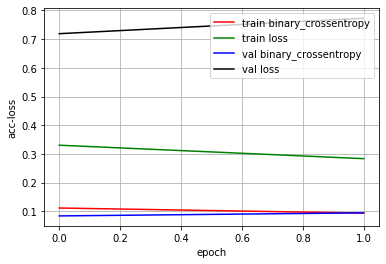

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 157612 samples, validate on 39404 samples
Epoch 1/10


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


157612/157612 - 10s - loss: 0.3240 - binary_crossentropy: 0.1076 - val_loss: 0.6754 - val_binary_crossentropy: 0.1031
Epoch 2/10
157612/157612 - 8s - loss: 0.2846 - binary_crossentropy: 0.0969 - val_loss: 0.8768 - val_binary_crossentropy: 0.0704
Epoch 3/10
157612/157612 - 7s - loss: 0.2593 - binary_crossentropy: 0.0900 - val_loss: 0.9160 - val_binary_crossentropy: 0.1065
Model Wide&Deep's training log ...


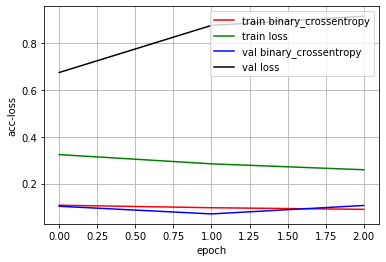

In [36]:
for key in models:
    train_model(models[key], key)
    predict_and_output(models[key], key, issamples)